# Load Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the Data


In [ ]:
# Core
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Display / misc
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
RANDOM_STATE = 30
np.random.seed(RANDOM_STATE)


In [ ]:
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

# If you're offline, replace `url` with a local file path.
df_raw = pd.read_csv(url)  # encoding handled automatically; CSV is clean
df = df_raw.copy()

# Quick sanity checks
print(df.shape)
df.head()


(887, 8)


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


# Data Cleaning


## Handling missing values


In [ ]:
# ===== 3.1 Missingness audit =====
missing_report = pd.DataFrame({
    "missing_count": df.isna().sum().sort_values(ascending=False),
    "missing_%": (df.isna().mean()*100).round(2).sort_values(ascending=False)
})
missing_report


,missing_count,missing_%
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
Siblings/Spouses Aboard,0,0.0
Parents/Children Aboard,0,0.0
Fare,0,0.0


In [ ]:
# ===== 3.1 Imputations (robust, conditional) =====

# Helper: available columns
cols = set(df.columns)


if "Age" in cols:
    group_keys = [c for c in ["Sex", "Pclass"] if c in cols]
    if group_keys:
        age_group_medians = df.groupby(group_keys)["Age"].median()
        def impute_age(row):
            if pd.notna(row["Age"]):
                return row["Age"]
            key = tuple(row[k] for k in group_keys)
            try:
                return age_group_medians.loc[key]
            except KeyError:
                return df["Age"].median()
        df["Age"] = df.apply(impute_age, axis=1)
    else:
        df["Age"] = df["Age"].fillna(df["Age"].median())


if "Fare" in cols:
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())


if "Cabin" in cols:
    df["HasCabin"] = df["Cabin"].notna().astype(int)
else:

    df["HasCabin"] = 0

# Re-check
df.isna().sum()


,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
Siblings/Spouses Aboard,0
Parents/Children Aboard,0
Fare,0
HasCabin,0


## Removing duplicates


In [ ]:
# ===== 3.2 Duplicates =====
dup_count = df.duplicated().sum()
print(f"Duplicates found: {dup_count}")
df = df.drop_duplicates().reset_index(drop=True)


Duplicates found: 0


## Quick View for the the data


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
 8   HasCabin                 887 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 62.5+ KB


In [ ]:
df.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,HasCabin
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000,887.0
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542,0.0
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204,0.0
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000,0.0
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500,0.0
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420,0.0
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750,0.0
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920,0.0


## Converting data types


In [ ]:
# ===== 3.4 Dtype corrections =====
dtype_plan = {}
if "Survived" in cols: dtype_plan["Survived"] = "int64"
if "Pclass"   in cols: dtype_plan["Pclass"]   = "int64"
if "Name"     in cols: dtype_plan["Name"]     = "string"
if "Sex"      in cols: dtype_plan["Sex"]      = "category"
if "Age"      in cols: dtype_plan["Age"]      = "int64"
if "SibSp"    in cols: dtype_plan["SibSp"]    = "int64"
if "Parch"    in cols: dtype_plan["Parch"]    = "int64"
if "Ticket"   in cols: dtype_plan["Ticket"]   = "string"
if "Fare"     in cols: dtype_plan["Fare"]     = "float64"
if "Cabin"    in cols: dtype_plan["Cabin"]    = "string"
dtype_plan["HasCabin"] = "int64"

df = df.astype(dtype_plan)
df.dtypes


,0
Survived,int64
Pclass,int64
Name,string[python]
Sex,category
Age,int64
Siblings/Spouses Aboard,int64
Parents/Children Aboard,int64
Fare,float64
HasCabin,int64


## Check for outliers


In [ ]:
# ===== 3.5 Outlier detection =====
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

iqr_outliers = {}
for col in num_cols:
    series = df[col].dropna()
    if series.empty:
        iqr_outliers[col] = 0
        continue
    lo, hi = iqr_bounds(series)
    iqr_outliers[col] = ((df[col] < lo) | (df[col] > hi)).sum()

pd.Series(iqr_outliers, name="IQR_outlier_count").sort_values(ascending=False)


,IQR_outlier_count
Parents/Children Aboard,213
Fare,116
Siblings/Spouses Aboard,46
Age,10
Survived,0
Pclass,0
HasCabin,0


##  Correct data types


## Fix inconsistent data
Look for inconsistencies in the data, like spelling variations, different

In [ ]:
# ===== 3.6 Standardization =====
for c in df.select_dtypes(include=["string"]).columns:
    df[c] = df[c].str.strip()

# Sex standardization
if "Sex" in df.columns:
    df["Sex"] = df["Sex"].astype("string").str.lower().map({
        "male": "male", "m": "male", "man": "male",
        "female": "female", "f": "female", "woman": "female"
    }).fillna(df["Sex"]).astype("category")

# Pclass validation
if "Pclass" in df.columns:
    df = df[df["Pclass"].isin([1, 2, 3])].copy()
    df["Pclass"] = df["Pclass"].astype("int64")


# Data Preprocessing


## Renaming columns


In [ ]:
# ===== 4.1 Rename to snake_case =====
def to_snake(name: str) -> str:
    return (
        name.strip()
            .replace(" ", "_")
            .replace("-", "_")
            .replace("/", "_")
            .lower()
    )

df = df.rename(columns={c: to_snake(c) for c in df.columns})
df.columns.tolist()


['survived',
 'pclass',
 'name',
 'sex',
 'age',
 'siblings_spouses_aboard',
 'parents_children_aboard',
 'fare',
 'hascabin']

## Changing column order



In [ ]:
# ===== 4.2 Reorder columns =====
target = [c for c in ["survived"] if c in df.columns]
numeric = df.select_dtypes(include=["number"]).columns.tolist()
numeric = [c for c in numeric if c not in target]
categorical = df.select_dtypes(include=["category"]).columns.tolist()
stringish = df.select_dtypes(include=["string"]).columns.tolist()

new_order = target + numeric + categorical + stringish
df = df.reindex(columns=new_order)
df.head(2)


,survived,pclass,age,siblings_spouses_aboard,parents_children_aboard,fare,hascabin,sex,name
0,0,3,22,1,0,7.2500,0,male,Mr. Owen Harris Braund
1,1,1,38,1,0,71.2833,0,female,Mrs. John Bradley (Florence Briggs Thayer) Cum...


## Dropping unnecessary columns


In [ ]:
# ===== 4.3 Drop high-cardinality / messy columns =====
to_drop = [c for c in ["name", "ticket", "cabin"] if c in df.columns]
df_model = df.drop(columns=to_drop).copy()
df_model.head(2)


,survived,pclass,age,siblings_spouses_aboard,parents_children_aboard,fare,hascabin,sex
0,0,3,22,1,0,7.2500,0,male
1,1,1,38,1,0,71.2833,0,female


## Encoding categorical variables


In [ ]:
# ===== Encoding =====
# Ordinal لـ pclass
if "pclass" in df_model.columns:
    df_model["pclass"] = pd.Categorical(df_model["pclass"], categories=[1,2,3], ordered=True).codes

# One-hot
categoricals = [c for c in ["sex"] if c in df_model.columns]
df_encoded = pd.get_dummies(df_model, columns=categoricals, drop_first=True)
df_encoded.head(3)


,survived,pclass,age,siblings_spouses_aboard,parents_children_aboard,fare,hascabin,sex_male
0,0,2,22,1,0,7.2500,0,True
1,1,0,38,1,0,71.2833,0,False
2,1,2,26,0,0,7.9250,0,False


# Data Visualization


##Histograms


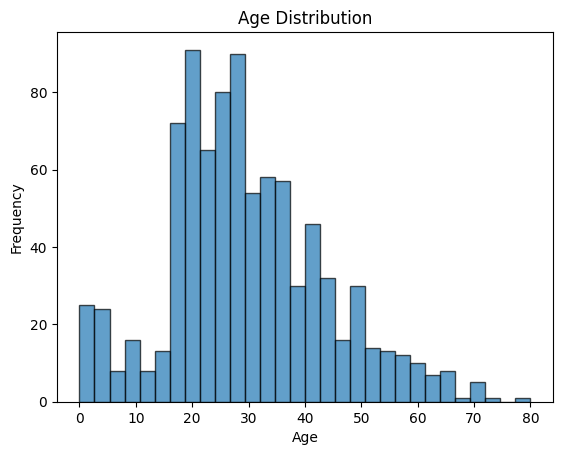

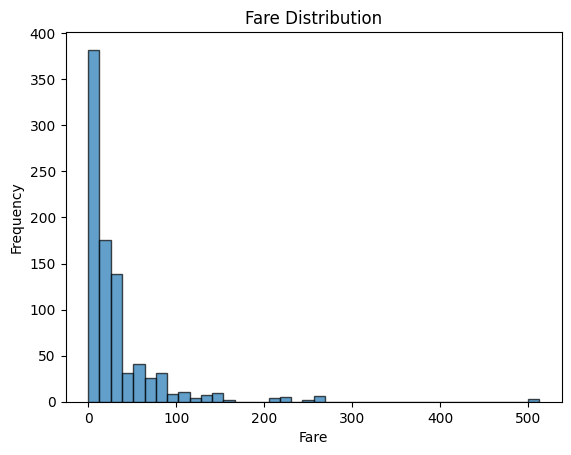

In [ ]:
# ===== 5.1 Histograms =====
if "age" in df.columns:
    df["age"].plot(kind="hist", bins=30, edgecolor="black", alpha=0.7, title="Age Distribution")
    plt.xlabel("Age"); plt.show()

if "fare" in df.columns:
    df["fare"].plot(kind="hist", bins=40, edgecolor="black", alpha=0.7, title="Fare Distribution")
    plt.xlabel("Fare"); plt.show()


## Box plots


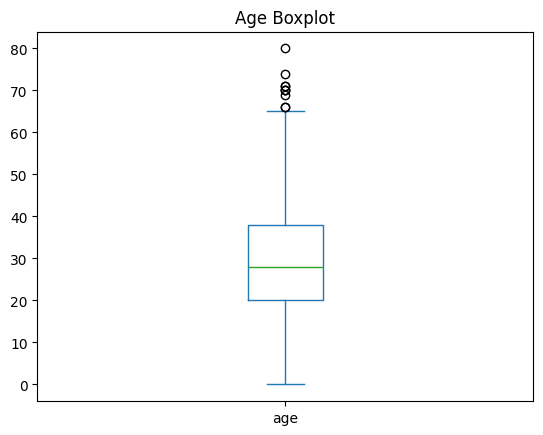

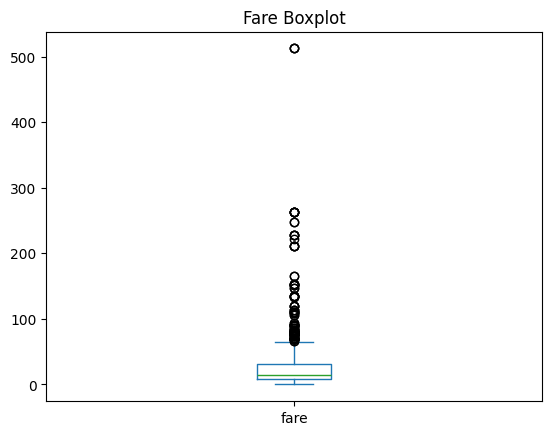

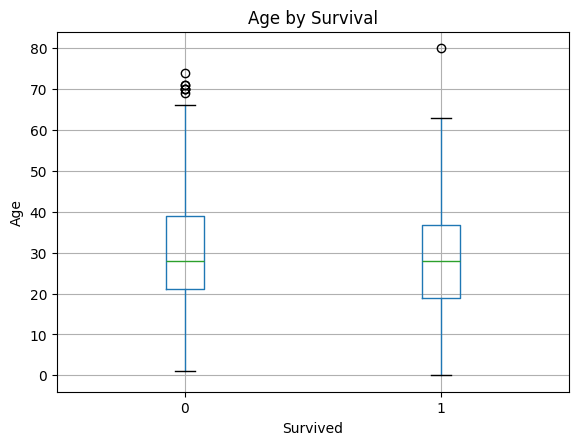

In [ ]:
# ===== 5.2 Box plots =====
if "age" in df.columns:
    df[["age"]].plot(kind="box", title="Age Boxplot"); plt.show()

if "fare" in df.columns:
    df[["fare"]].plot(kind="box", title="Fare Boxplot"); plt.show()

if {"age","survived"}.issubset(df.columns):
    df.boxplot(column="age", by="survived")
    plt.title("Age by Survival"); plt.suptitle("")
    plt.xlabel("Survived"); plt.ylabel("Age"); plt.show()


## Scatter plots


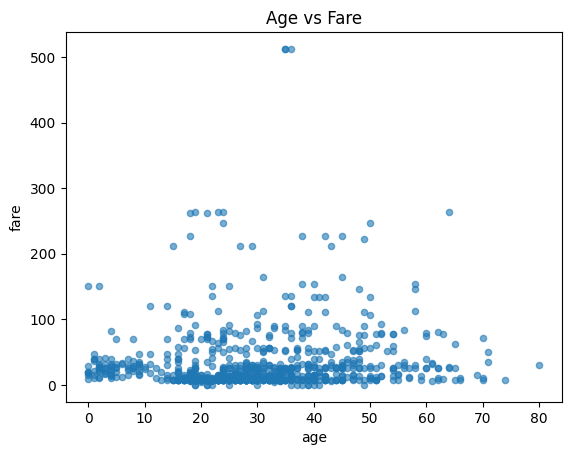

In [ ]:
# ===== 5.3 Scatter =====
if {"age","fare"}.issubset(df.columns):
    df.plot(kind="scatter", x="age", y="fare", alpha=0.6, title="Age vs Fare")
    plt.show()


## Bar plots


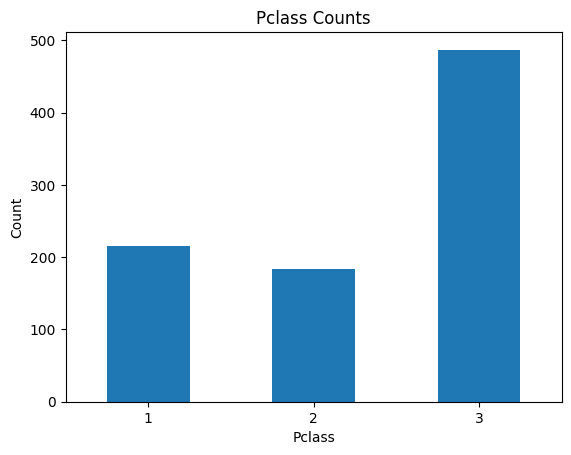

/tmp/ipython-input-2307922640.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df.groupby("sex")["survived"].mean()


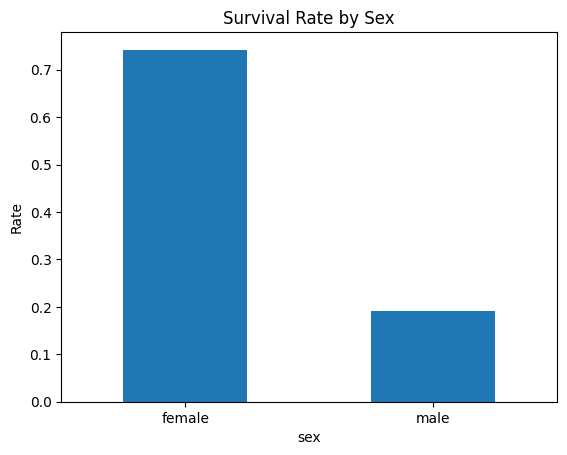

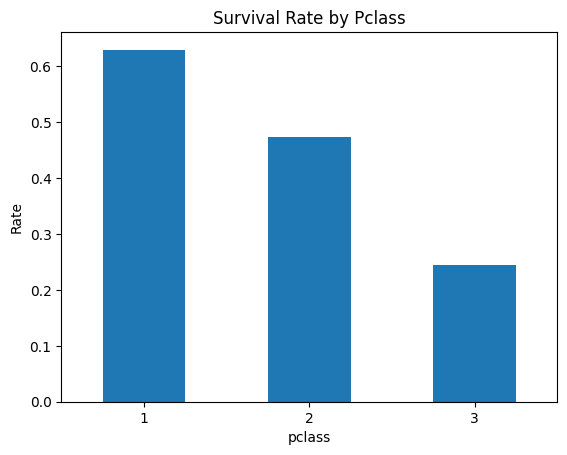

In [ ]:
# ===== 5.4 Bar plots =====
if "pclass" in df.columns:
    df["pclass"].value_counts().sort_index().plot(kind="bar", rot=0, title="Pclass Counts")
    plt.xlabel("Pclass"); plt.ylabel("Count"); plt.show()

if {"sex","survived"}.issubset(df.columns):
    (df.groupby("sex")["survived"].mean()
       .rename("survival_rate")
       .plot(kind="bar", rot=0, title="Survival Rate by Sex"))
    plt.ylabel("Rate"); plt.show()

if {"pclass","survived"}.issubset(df.columns):
    (df.groupby("pclass")["survived"].mean()
       .rename("survival_rate")
       .plot(kind="bar", rot=0, title="Survival Rate by Pclass"))
    plt.ylabel("Rate"); plt.show()


## Correlation heatmaps


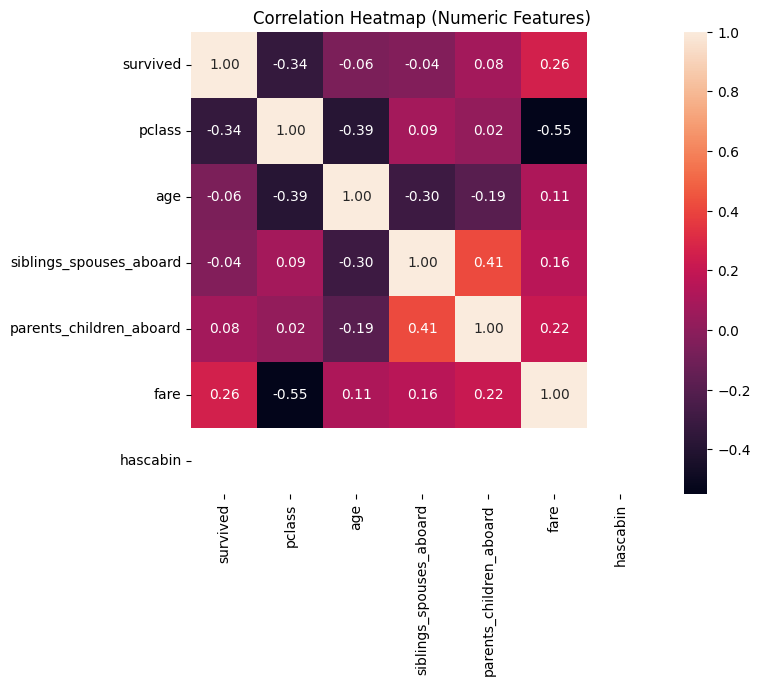

In [ ]:
# ===== 5.5 Correlation heatmap =====
num_df = df.select_dtypes(include=["number"])
if not num_df.empty:
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.show()


In [ ]:
def profile(df_):
    return {
        "shape": df_.shape,
        "columns": list(df_.columns),
        "dtypes": df_.dtypes.astype(str).to_dict(),
        "missing_%": (df_.isna().mean()*100).round(2).to_dict()
    }

profile(df)


{'shape': (887, 9),
 'columns': ['survived',
  'pclass',
  'age',
  'siblings_spouses_aboard',
  'parents_children_aboard',
  'fare',
  'hascabin',
  'sex',
  'name'],
 'dtypes': {'survived': 'int64',
  'pclass': 'int64',
  'age': 'int64',
  'siblings_spouses_aboard': 'int64',
  'parents_children_aboard': 'int64',
  'fare': 'float64',
  'hascabin': 'int64',
  'sex': 'category',
  'name': 'string'},
 'missing_%': {'survived': 0.0,
  'pclass': 0.0,
  'age': 0.0,
  'siblings_spouses_aboard': 0.0,
  'parents_children_aboard': 0.0,
  'fare': 0.0,
  'hascabin': 0.0,
  'sex': 0.0,
  'name': 0.0}}